# SOSE Data - cleaned version
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [12]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [13]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.962ebd58769948bcba01f00697db2d9e/status,


In [100]:
client.close()
cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe

In [2]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)
ds

<xarray.Dataset>
Dimensions:   (time: 438, Zl: 42, YC: 320, XC: 2160, Z: 42, XG: 2160, YG: 320,
               Zp1: 43, Zu: 42)
Coordinates: (12/26)
    Depth     (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * XG        (XG) float32 5.551e-17 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * YC        (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -25.04 -24.87 -24.71
    ...        ...
    iter      (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA        (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAs       (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAw       (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAz       (YG, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables: (12/56)
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_SLT  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_SLT  (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ...        ...
    oceFreez  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceQsw    (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceTAUX   (time, YC, XG) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceTAUY   (time, YG, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surForcS  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surForcT  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>

In [3]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700)#, roll_coords=True) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700)#, roll_coords=True) #ds dropping coords so it just holds data variables

In [4]:
coords_before_drop_true = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700, roll_coords=True) #ds split into coords
dsr_before_drop_true = ds.reset_coords(drop=True).roll(XC=700, XG=700, roll_coords=True) #ds dropping coords so it just holds data variables

In [5]:
dsr = dsr_before_drop_true.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop_true.drop(['XC', 'YC', 'XG', 'YG'])

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [7]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [8]:
lon_depth = coords_before_drop.XC.isel(**lon_range)
lat_depth = coords_before_drop.YC.isel(**lat_range)

lon_temp = coords_before_drop_true.XC.isel(**lon_range)
lat_temp = coords_before_drop_true.YC.isel(**lat_range)

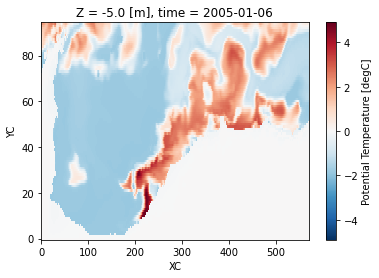

In [20]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [9]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [10]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [11]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [25]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.0b276cb3431c44caa0eaa229dd4e5685/status,


In [14]:
depth_max.load()

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]], dtype=float32)
Dimensions without coordinates: YC, XC

In [15]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.)).load()

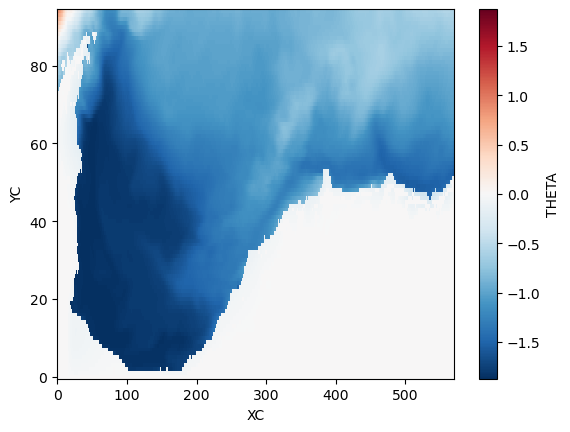

In [16]:
bottom_temp.plot()

In [38]:
np.ravel(bottom_temp).shape

(54150,)

In [ ]:
bottom_temp.shape

(95, 570)

In [40]:
95*570

54150

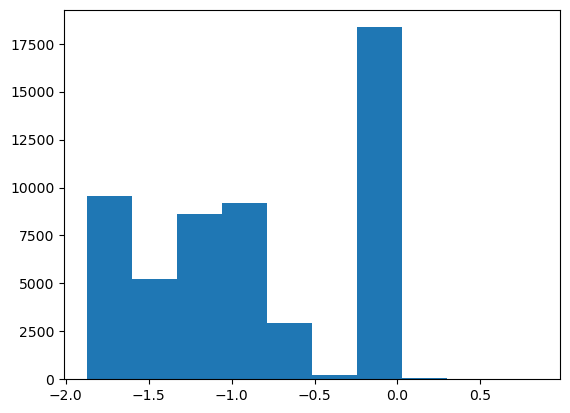

In [42]:
plt.hist(np.ravel(bottom_temp));

In [44]:
data

array([ 0.        ,  0.        ,  0.        , ..., -0.57839876,
       -0.5790265 , -0.5787111 ], dtype=float32)

In [50]:
data.shape

(54150,)

In [56]:
from scipy.stats import bootstrap
import numpy as np

#convert array to sequence
data = (np.ravel(bottom_temp),)

#calculate 95% bootstrapped confidence interval for median
bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile')

#view 95% boostrapped confidence interval
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=-0.8516185790300369, high=-0.8402930587530136)


In [29]:
depth_wg = coords.Depth.isel(**lat_range, **lon_range)
coords_wg = coords_before_drop.isel(**lat_range, **lon_range)

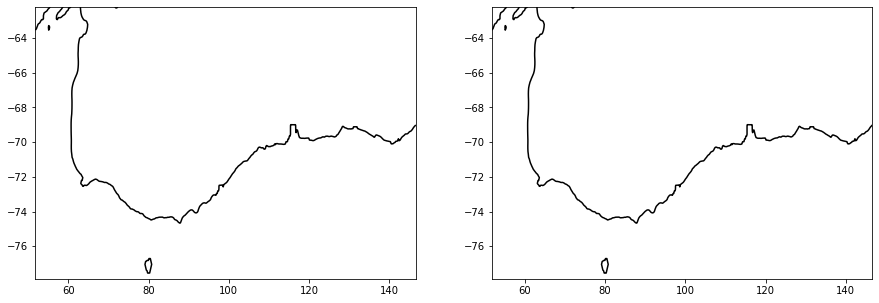

In [30]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,5))

ax0.contour(lon_depth, lat_depth, depth_wg, levels=[1000], colors='k')
ax1.contour(lon_depth, lat_depth, coords_wg.Depth, levels=[1000], colors='k')

In [68]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [31]:
bottom_temp['lat'] = lat_temp
bottom_temp['lon'] = lon_temp

#depth_wg['lat'] = lat
#depth_wg['lon'] = lon
#depth_wg.load()

In [32]:
bottom_temp

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59500206,  0.59372324,  0.5860209 , ..., -0.61448747,
        -0.61401767, -0.6136384 ],
       [ 0.7132437 ,  0.7120261 ,  0.7027545 , ..., -0.5988263 ,
        -0.59873897, -0.5980881 ],
       [ 0.8445248 ,  0.8352686 ,  0.8186579 , ..., -0.57839876,
        -0.5790265 , -0.5787111 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92

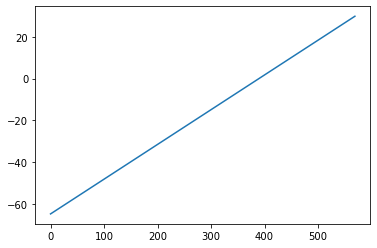

In [49]:
lon_fixed = lon_temp.values
lon_fixed[lon_fixed > 180] -= 360
plt.plot(lon_fixed)

In [33]:
test = xr.DataArray(coords_wg.Depth.values, coords={'YC':lat_temp, 'XC':lon_temp}, name='depth')

In [34]:
test

<xarray.DataArray 'depth' (YC: 95, XC: 570)>
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [3591.8472, 3593.2075, 3534.9768, ..., 5161.79  , 5156.6294,
        5153.4375],
       [3811.2007, 3542.6968, 3187.7976, ..., 5180.5894, 5172.557 ,
        5167.368 ],
       [3342.9731, 3062.174 , 2873.0115, ..., 5191.195 , 5185.343 ,
        5178.9673]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92

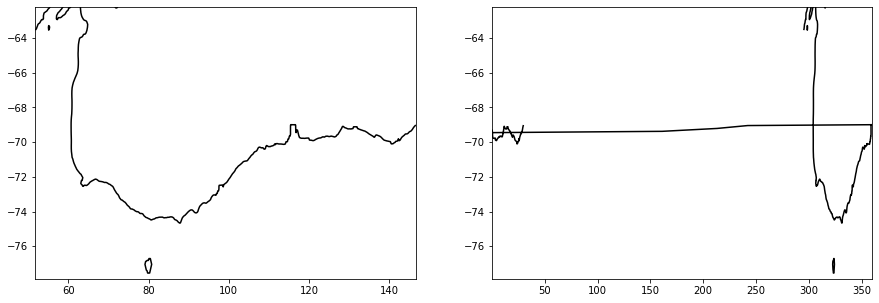

In [35]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,5))

ax0.contour(lon_depth, lat_depth, test, levels=[1000], colors='k')
ax1.contour(lon_temp, lat_temp, test, levels=[1000], colors='k')

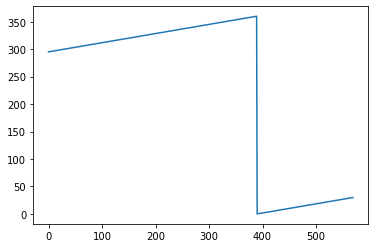

In [40]:
plt.plot(lon_temp.values)

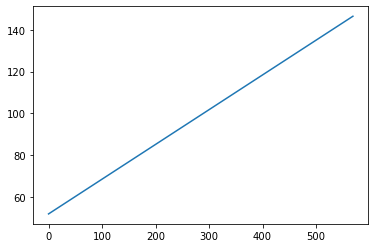

In [41]:
plt.plot(lon_depth.values)

In [50]:
bottom_temp = bottom_temp.assign_coords({'lon': ('XC', lon_fixed)})
bottom_temp

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59500206,  0.59372324,  0.5860209 , ..., -0.61448747,
        -0.61401767, -0.6136384 ],
       [ 0.7132437 ,  0.7120261 ,  0.7027545 , ..., -0.5988263 ,
        -0.59873897, -0.5980881 ],
       [ 0.8445248 ,  0.8352686 ,  0.8186579 , ..., -0.57839876,
        -0.5790265 , -0.5787111 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92

In [98]:
depth = coords_wg.Depth.assign_coords({'lon': ('XC', lon_fixed)}).swap_dims({'XC': 'lon'})
depth

<xarray.DataArray 'Depth' (YC: 95, lon: 570)>
dask.array<getitem, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Coordinates:
    XC       (lon) float32 51.75 51.92 52.08 52.25 ... 146.1 146.2 146.4 146.6
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * lon      (lon) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
Attributes:
    coordinate:     XC YC
    long_name:      ocean depth
    standard_name:  ocean_depth
    units:          m

In [101]:
depth.to_netcdf('depth.nc', mode='w')

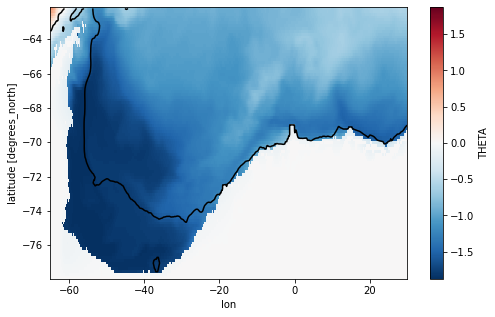

In [53]:
fig, ax = plt.subplots(figsize=(8,5))

ax.contour(lon_fixed, lat_depth, test, levels=[1000], colors='k')
bottom_temp.swap_dims({'XC': 'lon'}).plot(ax=ax)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


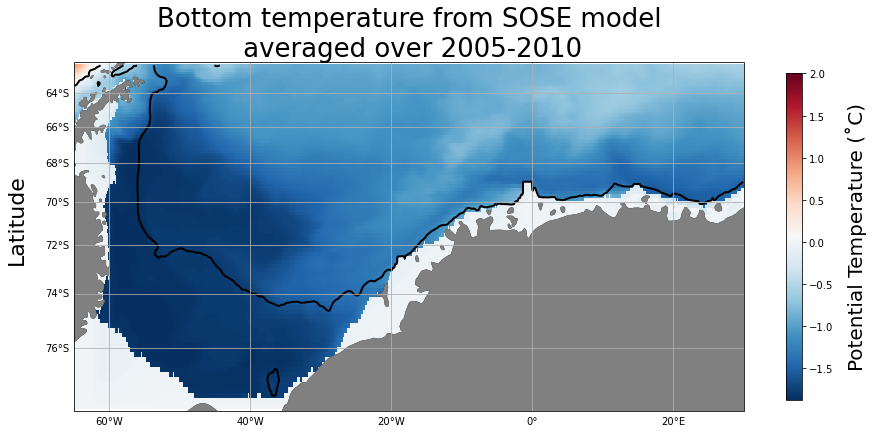

In [96]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SOSE model\n averaged over 2005-2010', fontsize=26)
plt.savefig('bot-temp-sose-1km-isobath.pdf');

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [57]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.0b276cb3431c44caa0eaa229dd4e5685/status,


In [58]:
std_temp = temp_wg.std('time').load()

In [59]:
std_temp

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.9401149 , 1.9315456 , 1.925773  , ..., 1.6168126 ,
         1.6183969 , 1.6180696 ],
        [1.9405234 , 1.9307938 , 1.9231234 , ..., 1.6200324 ,
         1.6224138 , 1.6237788 ],
        [1.9323751 , 1.9223851 , 1.9137712 , ..., 1.6269828 ,
         1.6288462 , 1.6300234 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [60]:
#this gives us the depth of the bottom cell
depth_max_std_temp = dsr.Z.where(std_temp.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [61]:
depth_max_std_temp

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]], dtype=float32)
Dimensions without coordinates: YC, XC

In [62]:
bottom_std_temp = std_temp.sel(Z=depth_max_std_temp.fillna(0.)).load()

In [65]:
bottom_std_temp = bottom_std_temp.assign_coords({'lon': ('XC', lon_fixed)})

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


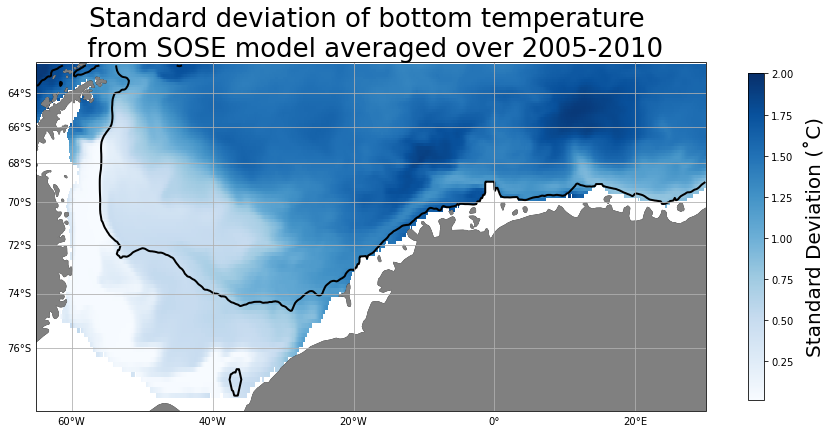

In [95]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_std_temp.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from SOSE model averaged over 2005-2010', fontsize=26)
plt.savefig('std-bot-temp-sose-1km-isobath.pdf');

<span style='color:Green'> **The darker the blue, the more the datapoint is away from mean temperature**

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)
    
* Don't so Z score in this case

## <span style='color:Red'> Bottom Temperature Z-score (end)

## BOTTOM SALT

In [71]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [72]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [73]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [76]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

Task exception was never retrieved
future: <Task finished name='Task-1885' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2080' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit


In [77]:
bottom_slt['lat'] = coords_before_drop.YC.isel(**lat_range)
bottom_slt['lon'] = coords_before_drop.XC.isel(**lon_range)

In [78]:
bottom_slt = bottom_slt.assign_coords({'lon': ('XC', lon_fixed)})
bottom_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [33.708538, 33.709415, 33.709522, ..., 33.853043, 33.854958,
        33.856647],
       [33.72277 , 33.723537, 33.72321 , ..., 33.855934, 33.8571  ,
        33.858185],
       [33.741817, 33.74131 , 33.739555, ..., 33.85897 , 33.859295,
        33.85984 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float32 51.75 51.92 52.08 52.25 ... 146.1 146.2 146.4 146.6
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


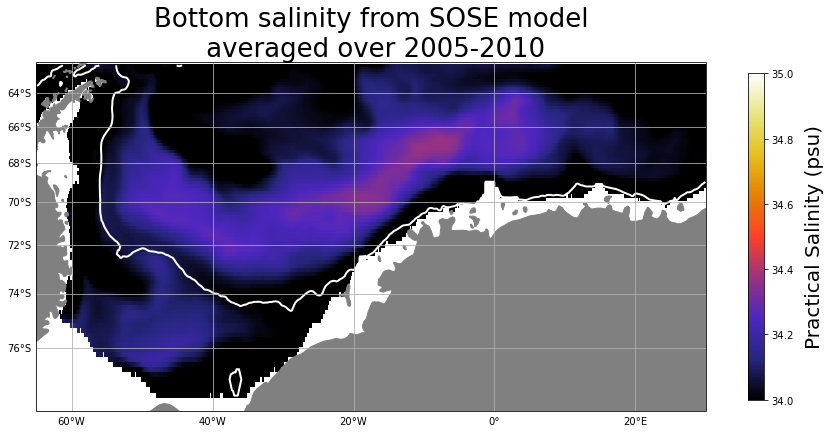

In [94]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords_wg.Depth, levels=[1000], colors='white', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_slt.where(surface_mask), transform=ccrs.PlateCarree(), vmin=34, vmax=35, cmap='CMRmap')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=26 )
plt.savefig('bot-salt-sose-1km-isobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [85]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.0b276cb3431c44caa0eaa229dd4e5685/status,


In [86]:
std_slt = slt_wg.std('time').load()

In [87]:
#this gives us the depth of the bottom cell
depth_max_std_slt = dsr.Z.where(std_slt.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [88]:
bottom_std_slt = std_slt.sel(Z=depth_max_std_slt.fillna(0.)).load()

In [89]:
bottom_std_slt = bottom_std_slt.assign_coords({'lon': ('XC', lon_fixed)})
bottom_std_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16349815, 0.16455886, 0.16600156, ..., 0.26004484, 0.2624796 ,
        0.26455685],
       [0.15929526, 0.15990709, 0.16109149, ..., 0.24494264, 0.24762833,
        0.2505836 ],
       [0.15186515, 0.15275356, 0.15425907, ..., 0.23001364, 0.23254564,
        0.2355742 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
Dimensions without coordinates: YC, XC

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


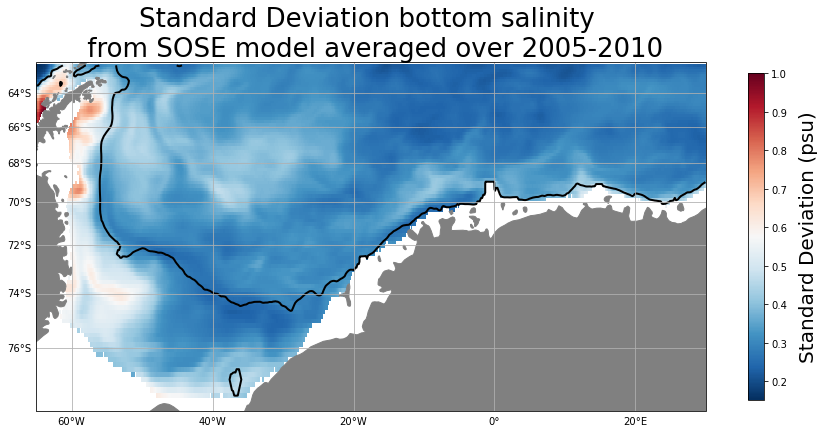

In [92]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords_wg.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_std_slt.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation bottom salinity \n from SOSE model averaged over 2005-2010', fontsize=26 )
plt.savefig('std-bot-salt-sose-1km-isobath.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)
    
* Don't do Z score in the case

## <span style='color:Red'> Bottom Salinity Z-score (end)